In [18]:
from model import CNN, ANN
from get_data import load_data
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt


In [8]:
train_dset = dsets.MNIST(
        root = "./data",
        train = True,
        transform = transforms.ToTensor(),
        download = True
    )

test_dset = dsets.MNIST(
    root = "./data",
    train = False,
    transform = transforms.ToTensor()
)

In [26]:
print(len(train_dset))
print(len(test_dset))

60000
10000


In [27]:
first_image, first_label = train_dset[0]
print(first_image.shape)
print(f"First label: {first_label}")

torch.Size([1, 28, 28])
First label: 5


In [29]:
train_loader, val_loader, test_loader = load_data(batch_size=100)
train_images, train_labels = next(iter(train_loader))

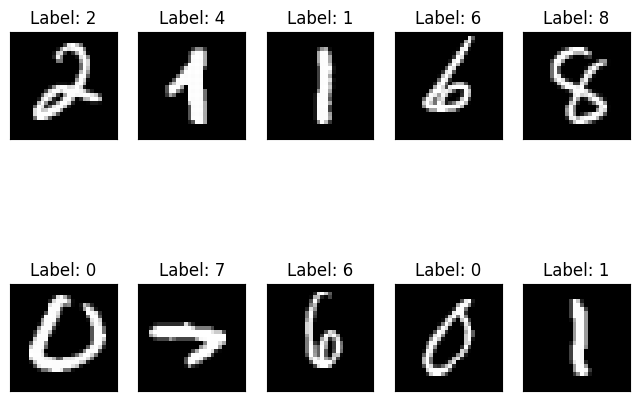

In [33]:
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].squeeze(), cmap='gray')  # Use squeeze() to remove the channel dimension
    plt.title(f"Label: {train_labels[i]}")
plt.show()